## Using feature engineering on Ridge model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
%matplotlib inline

In [2]:
train = pd.read_csv('./datasets/train_cleaned_2.csv')

In [3]:
train.head(3)

,Id,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,...,Misc Feature_Othr,Misc Feature_Shed,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,109,60,0.0,13517,6,8,1976,2005,289.0,4,...,0,0,0,0,0,0,0,0,0,1
1,544,60,43.0,11492,7,5,1996,1997,132.0,4,...,0,0,0,0,0,0,0,0,0,1
2,153,20,68.0,7922,5,7,1953,2007,0.0,3,...,0,0,0,0,0,0,0,0,0,1


In [4]:
test = pd.read_csv('./datasets/test_cleaned.csv')

In [5]:
test.head(3)

,Id,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,...,Misc Feature_Shed,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,190,69.0,9142,6,8,1910,1950,0.0,3,...,0,0,0,0,0,0,0,0,0,1
1,2718,90,0.0,9662,5,4,1977,1977,0.0,3,...,0,0,0,0,0,0,0,0,0,1
2,2414,60,58.0,17104,7,5,2006,2006,0.0,4,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# list of columns in test set but not in train set
[i for i in test.columns if i not in train.columns]

['Roof Matl_Metal',
 'Roof Matl_Roll',
 'Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Mas Vnr Type_CBlock',
 'Heating_GasA',
 'Sale Type_VWD']

In [7]:
# remove said columns above from test set
test.drop([i for i in test.columns if i not in train.columns],
          axis = 1, inplace = True)

In [8]:
test.shape

(879, 192)

In [9]:
# filter features with high correlations with SalePrice
corr = train.corr()['SalePrice']
high_corr = pd.DataFrame(corr[corr > 0.50])
high_corr = high_corr.sort_values(
    by = 'SalePrice', ascending = False).drop('SalePrice')

In [10]:
high_corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Kitchen Qual',
       'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Garage Cars',
       'Bsmt Qual', 'Year Built', 'Garage Finish', 'Year Remod/Add',
       'Fireplace Qu', 'Full Bath', 'Foundation_PConc', 'Mas Vnr Area',
       'TotRms AbvGrd'],
      dtype='object')

## Feature engineering

In [11]:
# function to plot histogram and scatterplot
def plotter(ft):
    plt.figure(figsize = (20,8))
    
    ax1 = plt.subplot(121)
    ax1.hist(train[ft])
    plt.title('{}'.format(ft), size = 20)
    
    ax2 = plt.subplot(122)
    ax2.scatter(train['SalePrice'], train[ft])
    plt.xlabel('Sale Price', size = 15)
    plt.ylabel('{}'.format(ft), size = 15)
    plt.title('Correlation between Sale Price and {}'.format(ft), size = 20)

In [12]:
train['totalSF'] = train['Total Bsmt SF'] + train['1st Flr SF'] + train['2nd Flr SF']

In [13]:
test['totalSF'] = test['Total Bsmt SF'] + test['1st Flr SF'] + test['2nd Flr SF']

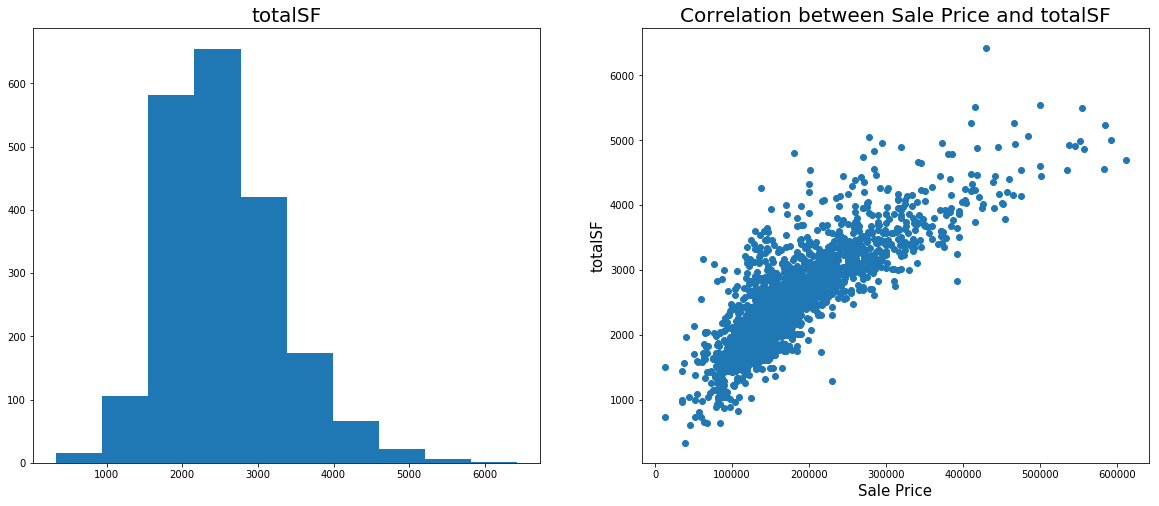

In [14]:
plotter('totalSF')

In [15]:
train['garage'] = train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']

In [16]:
test['garage'] = test['Garage Area'] * test['Garage Qual'] * test['Garage Cond']

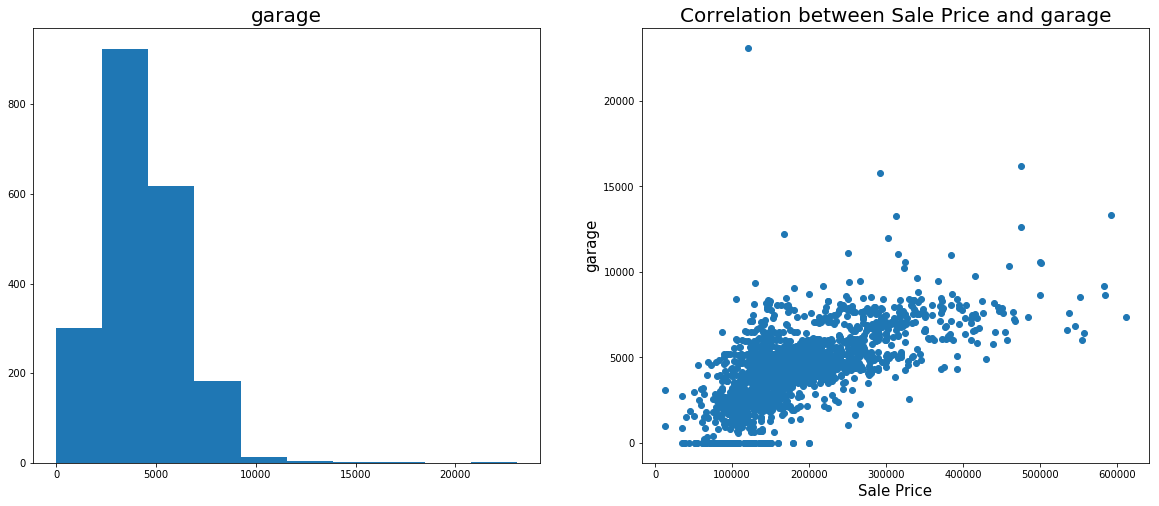

In [17]:
plotter('garage')

In [18]:
train['bathrooms'] = train['Bsmt Full Bath'] + train['Bsmt Half Bath'] + train['Full Bath'] + train['Half Bath']

In [19]:
test['bathrooms'] = test['Bsmt Full Bath'] + test['Bsmt Half Bath'] + test['Full Bath'] + test['Half Bath']

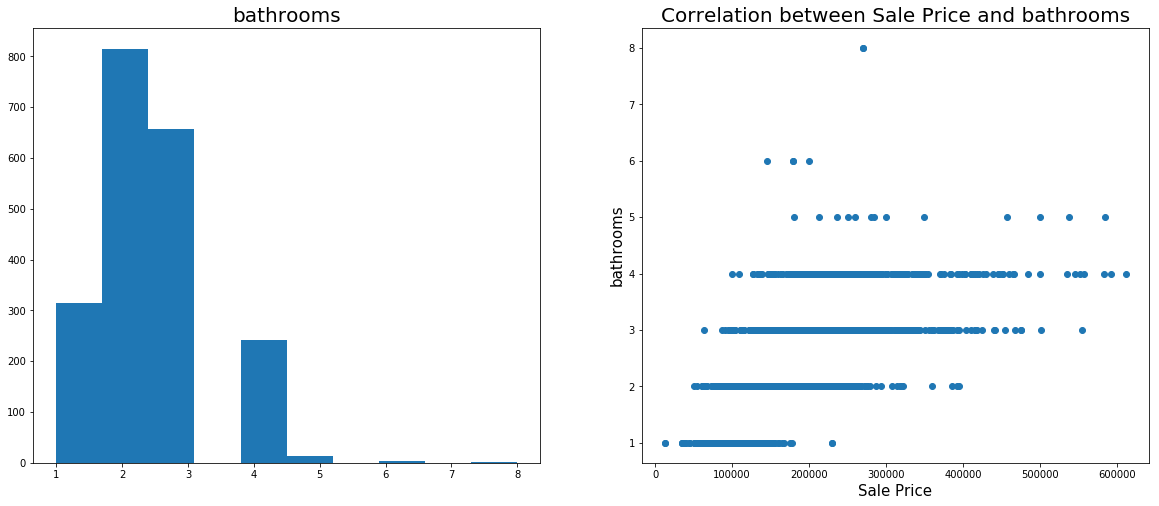

In [20]:
plotter('bathrooms')

In [21]:
train['basement'] = train['Bsmt Qual'] * train['Bsmt Cond'] * train['Total Bsmt SF']

In [22]:
test['basement'] = test['Bsmt Qual'] * test['Bsmt Cond'] * test['Total Bsmt SF']

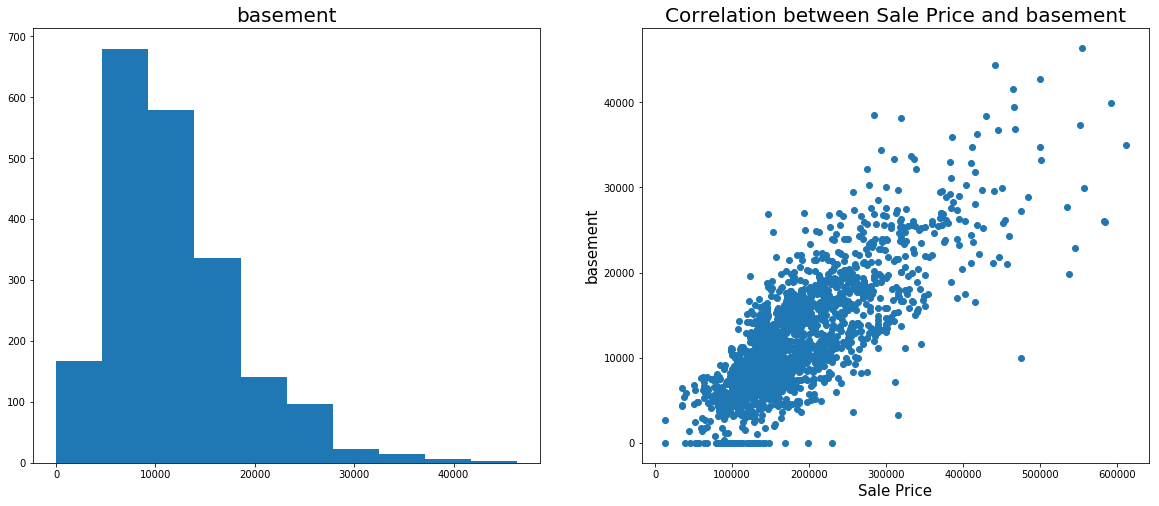

In [23]:
plotter('basement')

In [24]:
train['total_quality'] = train['Overall Qual'] + train['Exter Qual'] + train['Bsmt Qual'] + train['Kitchen Qual']

In [25]:
test['total_quality'] = test['Overall Qual'] + test['Exter Qual'] + test['Bsmt Qual'] + test['Kitchen Qual']

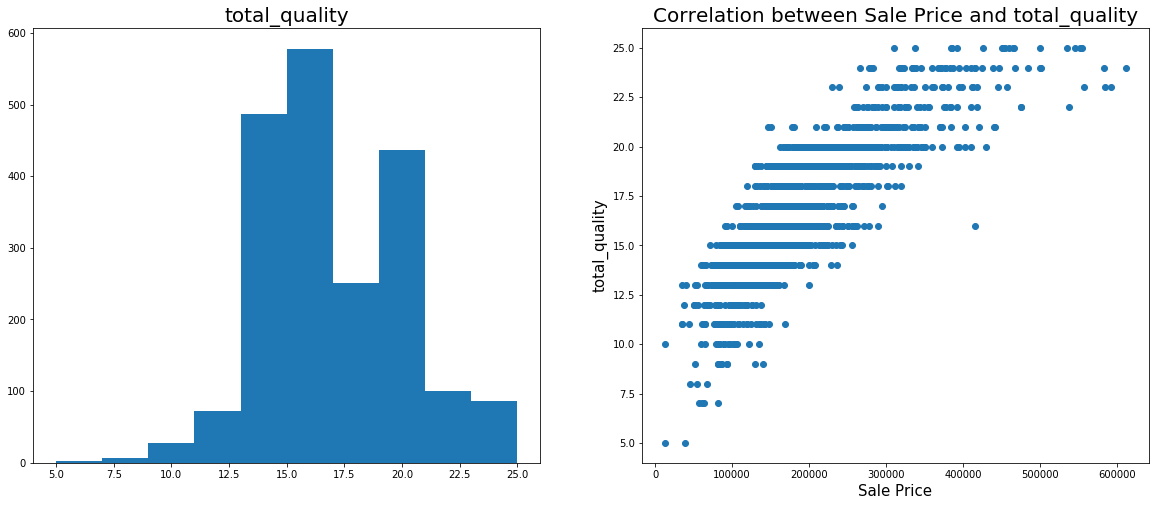

In [26]:
plotter('total_quality')

In [27]:
# train['rooms'] = train['TotRms AbvGrd'] + train['Bedroom AbvGr']

In [28]:
# train['fireplace'] = train['Fireplaces'] + train['Fireplace Qu']

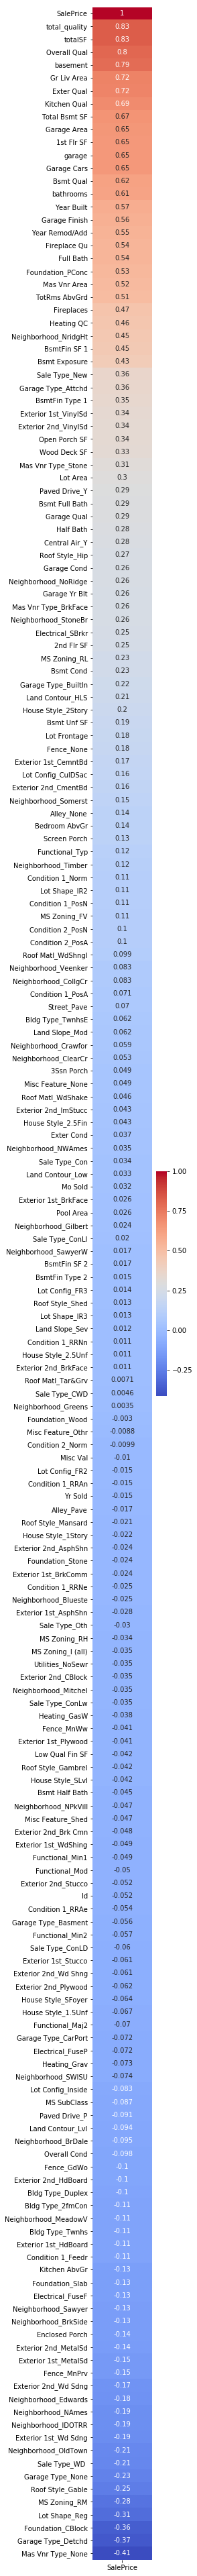

In [29]:
# inspect correlation between features and target
plt.figure(figsize = (2,70))
sns.heatmap(
    train.corr()[['SalePrice']].sort_values(
        by = 'SalePrice',
        ascending = False),
    annot = True,
    cmap = 'coolwarm'
)

## Ridge Regression Model

In [30]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [32]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [33]:
ridge_alphas = np.logspace(0, 5, 200)

ridge_optimal = RidgeCV(ridge_alphas, cv = 5)

ridge_optimal.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000e+00, 1.05956e+00, ..., 9.43788e+04, 1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [34]:
ridge = Ridge(alpha=ridge_optimal.alpha_)

In [35]:
ridge.fit(X_train_sc, y_train)

Ridge(alpha=230.0430119772919, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
ridge.score(X_train_sc, y_train)

0.9312648887204779

In [37]:
ridge.score(X_test_sc, y_test)

0.9083464871475408

In [38]:
cross_val_score(ridge,X_train_sc,y_train,cv=5).mean()

0.9056445203555497

In [39]:
pred_test = ridge.predict(X_test_sc)

In [40]:
np.sqrt(mean_squared_error(y_test, pred_test).mean())

23764.529184024446

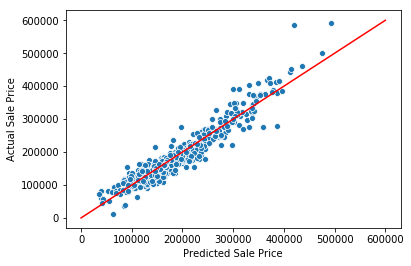

In [41]:
sns.scatterplot(pred_test, y_test)
plt.xlabel("Predicted Sale Price");
plt.ylabel("Actual Sale Price")
plt.plot([0, 600000], [0, 600000], c = "r");

## Kaggle Test Dataset Predictions

In [42]:
X = test

In [43]:
X_sc = ss.transform(X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [44]:
test_pred = ridge.predict(X_sc)

In [45]:
test['test_pred'] = test_pred

In [46]:
submission_3 = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test['test_pred']
})

In [47]:
# submission_3.to_csv('./datasets/submission_3.csv', index = False)